In [2]:
!nvidia-smi

Tue Jul  9 10:28:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   39C    P3             12W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os

for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
    print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath} .')

there are 2 directories and 0 images in 10_food_classes_10_percent .
there are 10 directories and 0 images in 10_food_classes_10_percent\test .
there are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_curry .
there are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_wings .
there are 0 directories and 250 images in 10_food_classes_10_percent\test\fried_rice .
there are 0 directories and 250 images in 10_food_classes_10_percent\test\grilled_salmon .
there are 0 directories and 250 images in 10_food_classes_10_percent\test\hamburger .
there are 0 directories and 250 images in 10_food_classes_10_percent\test\ice_cream .
there are 0 directories and 250 images in 10_food_classes_10_percent\test\pizza .
there are 0 directories and 250 images in 10_food_classes_10_percent\test\ramen .
there are 0 directories and 250 images in 10_food_classes_10_percent\test\steak .
there are 0 directories and 250 images in 10_food_classes_10_percent\test\sushi 

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE=(224,224)
BATCH_SIZE=32


train_dir='10_food_classes_10_percent/train/'
test_dir='10_food_classes_10_percent/test'

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print('Training data')
train_data_10percent=train_datagen.flow_from_directory(train_dir,
                                                       target_size=IMAGE_SIZE,
                                                       batch_size=BATCH_SIZE,
                                                       class_mode='categorical')

print('Testing data')
test_data_10percent=test_datagen.flow_from_directory(test_dir,
                                                     target_size=IMAGE_SIZE,
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='categorical')

Training data
Found 750 images belonging to 10 classes.
Testing data
Found 2500 images belonging to 10 classes.


In [14]:
import datetime

def create_tensorboard_callback(dir_name,exp_name):
    log_dir=dir_name + '/' + exp_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving Tensorboard log files to: {log_dir}")
    return tensorboard_callback

In [5]:
efficientnet_url="https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"
resnet_url="https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# create a function to create a model from a url
def create_model(model_url,num_classes=10):
    
    feature_extraction_layer=hub.KerasLayer(model_url,
                                            trainable=False, # freeze the already learned data
                                            name='feature_extraction_layer',
                                            input_shape=IMAGE_SIZE+(3,))
    model=tf.keras.Sequential([
        feature_extraction_layer,
        layers.Dense(num_classes,activation='softmax',name='output_layer')
    ])
    
    return model

In [8]:
# creating model
resnet_model=create_model(resnet_url,num_classes=train_data_10percent.num_classes)

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23561152  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,581,642
Trainable params: 20,490
Non-trainable params: 23,561,152
_________________________________________________________________


In [15]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

history_resnet=resnet_model.fit(train_data_10percent,
                                epochs=5, 
                                steps_per_epoch=len(train_data_10percent),
                                validation_data=test_data_10percent,
                                validation_steps=len(test_data_10percent),
                                callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                       exp_name='resnet50v2')])

Saving Tensorboard log files to: tensorflow_hub/resnet50v2/20240710-065433
Epoch 1/5
24/24 [==============================] - 28s 1s/step - loss: 0.3409 - accuracy: 0.9160 - val_loss: 0.5506 - val_accuracy: 0.8176
Epoch 2/5
24/24 [==============================] - 22s 960ms/step - loss: 0.2242 - accuracy: 0.9560 - val_loss: 0.5702 - val_accuracy: 0.8044
Epoch 3/5
24/24 [==============================] - 23s 975ms/step - loss: 0.1784 - accuracy: 0.9707 - val_loss: 0.5218 - val_accuracy: 0.8276
Epoch 4/5
24/24 [==============================] - 23s 983ms/step - loss: 0.1376 - accuracy: 0.9800 - val_loss: 0.5267 - val_accuracy: 0.8236
Epoch 5/5
24/24 [==============================] - 23s 993ms/step - loss: 0.1024 - accuracy: 0.9933 - val_loss: 0.5264 - val_accuracy: 0.8232


In [16]:
# plotting curve
import matplotlib.pyplot as plt

def plot_loss_curve(history):
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']
    
    epochs=range(len(history.history['loss']))
    
    plt.plot(epochs,loss,label='training_loss')
    plt.plot(epochs,val_loss,label='val_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs,accuracy,label='training_accuracy')
    plt.plot(epochs,val_accuracy,label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

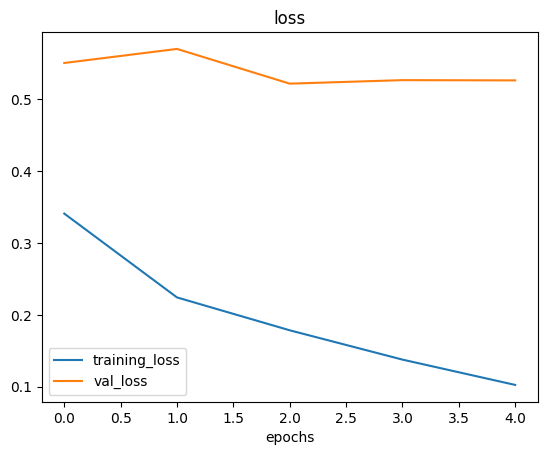

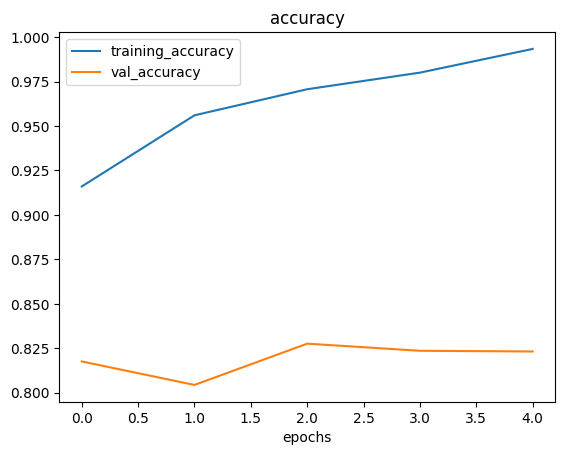

In [17]:
plot_loss_curve(history_resnet)

In [20]:
efficientnet_model=create_model(efficientnet_url)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

history_efficientnet=efficientnet_model.fit(train_data_10percent,
                                      epochs=5,
                                      steps_per_epoch=len(train_data_10percent),
                                      validation_data=test_data_10percent,
                                      validation_steps=len(test_data_10percent),
                                      callbacks=[create_tensorboard_callback('tensorflow_hub','efficientnetb0')])

Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20240710-072356
Epoch 1/5
24/24 [==============================] - 24s 622ms/step - loss: 1.8878 - accuracy: 0.4240 - val_loss: 1.3138 - val_accuracy: 0.7396
Epoch 2/5
24/24 [==============================] - 12s 510ms/step - loss: 1.0676 - accuracy: 0.7773 - val_loss: 0.8707 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 12s 514ms/step - loss: 0.7585 - accuracy: 0.8253 - val_loss: 0.6931 - val_accuracy: 0.8504
Epoch 4/5
24/24 [==============================] - 12s 513ms/step - loss: 0.6067 - accuracy: 0.8587 - val_loss: 0.6022 - val_accuracy: 0.8628
Epoch 5/5
24/24 [==============================] - 12s 517ms/step - loss: 0.5095 - accuracy: 0.8880 - val_loss: 0.5516 - val_accuracy: 0.8648


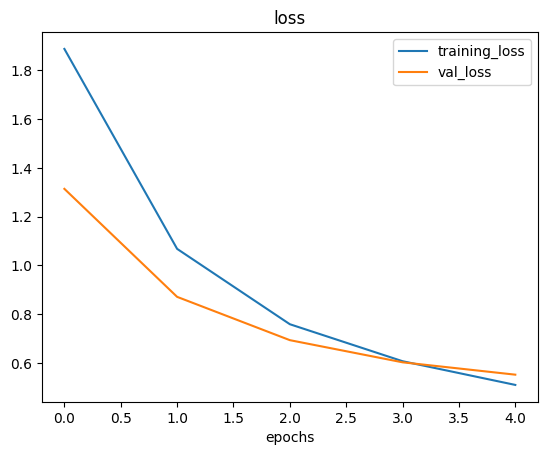

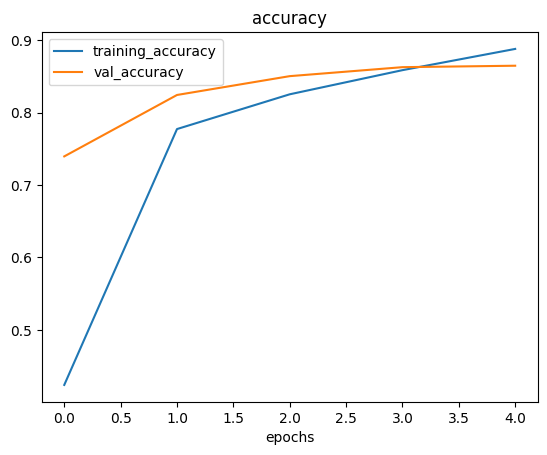

In [21]:
plot_loss_curve(history_efficientnet)

In [22]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [25]:
len(efficientnet_model.layers[0].weights)

309